In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/Challenge1

/gdrive/MyDrive/Challenge1


## Import Libraries

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random 
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

tfk = tf.keras
tfkl = tf.keras.layers

## Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Initialization

In [ ]:
!unzip dataset.zip

In [ ]:
dataset_dir = 'training'

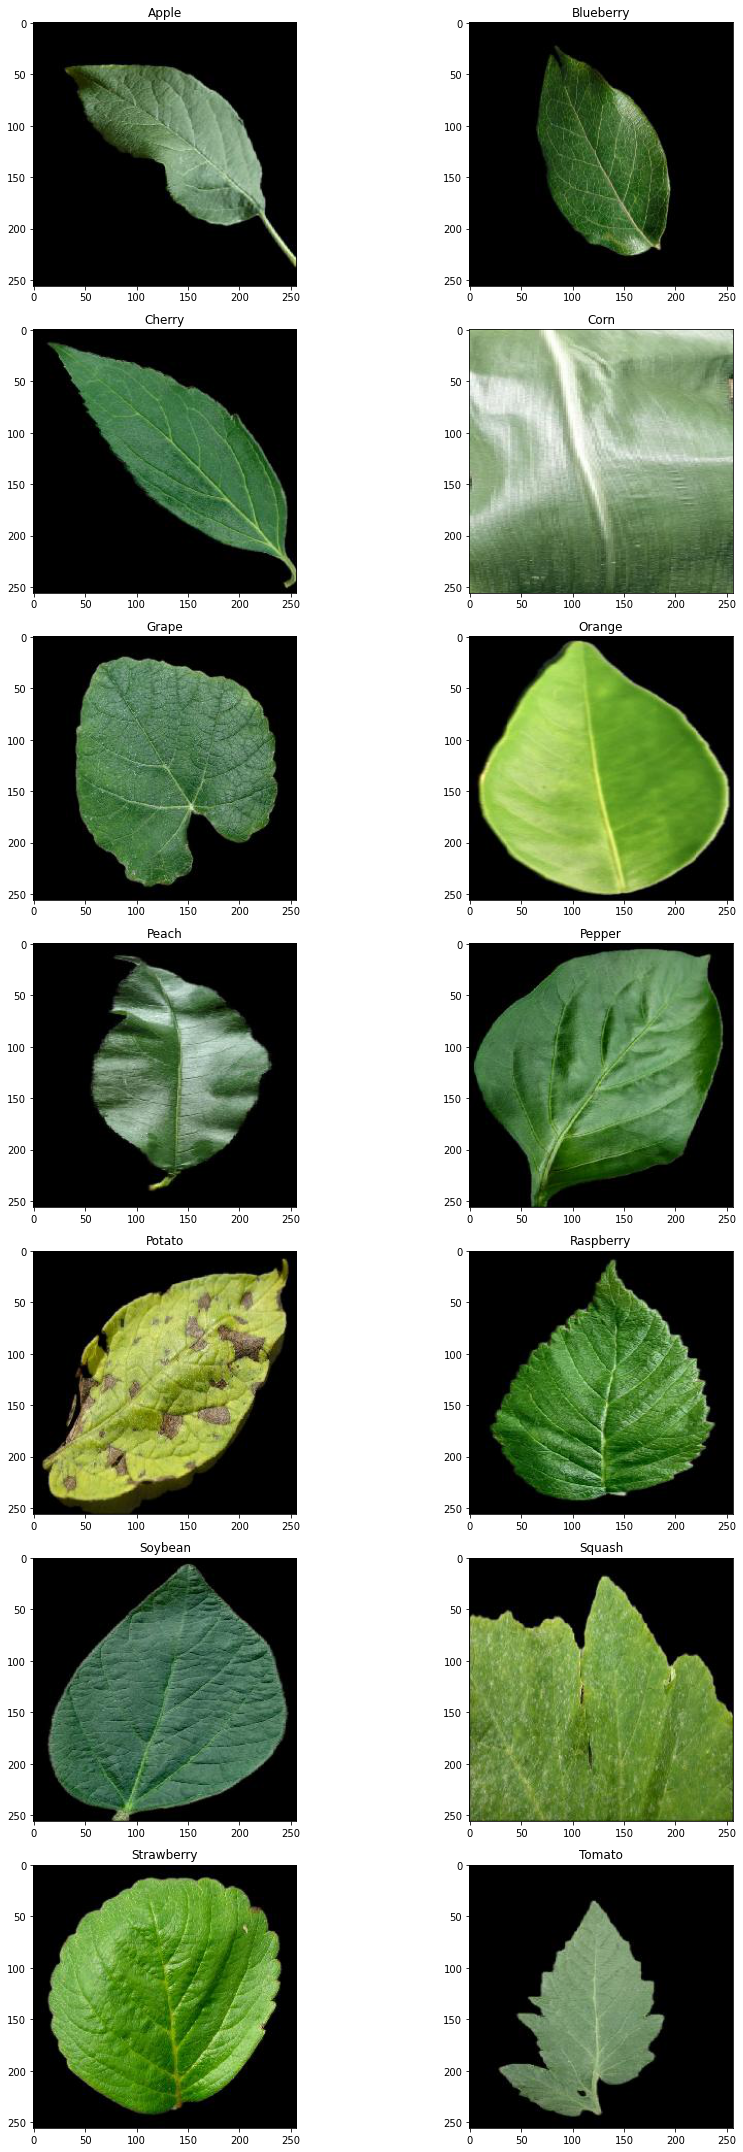

In [ ]:
# Plot example images from dataset
'''
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()
'''

In [ ]:
label_dict = {
    0: 'Apple',
    1: 'Blueberry',
    2: 'Cherry', 
    3: 'Corn',
    4: 'Grape',
    5:'Orange',
    6: 'Peach', 
    7:'Pepper',
    8: 'Potato',
    9: 'Raspberry',
    10: 'Soybean',
    11: 'Squash',
    12: 'Strawberry',
    13: 'Tomato'
    }

In [ ]:
# Use only if the shape of the image must be changed: it resizes the images
img_list = []
label_list = []


for key, label in label_dict.items():
  for _, _, filenames in os.walk('{}/{}/'.format(dataset_dir, label)): 
    for class_image in tqdm(filenames, desc=label):
      img = Image.open('{}/{}/{}'.format(dataset_dir, label, class_image))
      img = img.resize((50,50)) #resize of the image

      img_list.append(np.array(img))
      label_list.append(key)

img_list = np.array(img_list)
label_list = np.array(label_list)

In [ ]:
# Find broken images
broken_imgs = []
for i, im in enumerate(img_list):
  if im.shape != (50, 50, 3):
    broken_imgs.append(i)

In [ ]:
'''
print('Number of broken images: {}'.format(len(broken_imgs)))
print('Number of images: {}'.format(len(img_list)))
'''

Number of broken images: 1
Number of images: 17728


In [ ]:
# Delete broken images
if len(broken_imgs) > 0:
  for b in broken_imgs:
    img_list.pop(b)
    label_list.pop(b)

In [ ]:
# Balance the classes with some copies of the images
cls, cnts = np.unique(label_list, return_counts=True)
max_cnt = max(cnts)

balanced_img_list = []
balanced_label_list = []
for c, cnt in tqdm(zip(cls, cnts)):
  diff = round(max_cnt / cnt)
  c_img = img_list[label_list == c]
  c_label = label_list[label_list == c]

  c_img = np.repeat(c_img, diff, axis=0)
  c_label = np.repeat(c_label, diff, axis=0)

  balanced_img_list.append(c_img)
  balanced_label_list.append(c_label)

balanced_img_list = np.concatenate(balanced_img_list)
balanced_label_list = np.concatenate(balanced_label_list)

14it [00:00, 67.77it/s]


In [ ]:
label_list = balanced_label_list
img_list = balanced_img_list

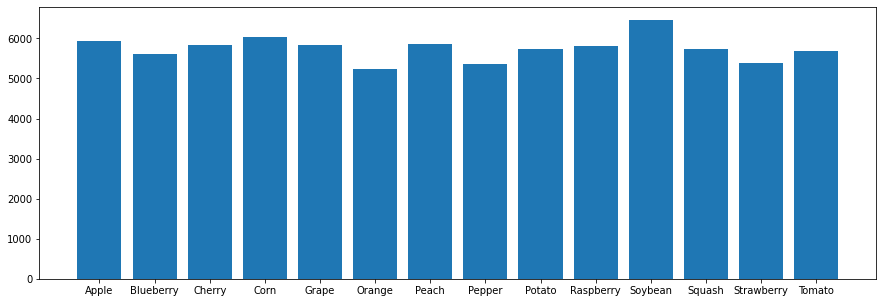

In [ ]:
# Show the distribution of the classes after the changes in the classes
cnts = np.unique(label_list, return_counts=True)
plt.figure(figsize=(15, 5))
plt.bar(x=label_dict.values(), height=cnts[1])
plt.show()

Resized image shape (50, 50, 3)


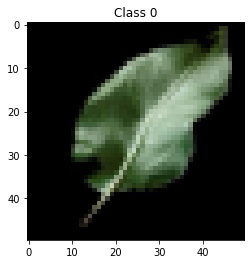

In [ ]:
# Try to show a resized image
print("Resized image shape", img_list[0].shape)
plt.imshow(img_list[0])
plt.title("Class {}".format(label_list[0]))
plt.show()

## Preprocessing of data

In [ ]:
# Normalize the data (in 0-1)
img_list= img_list / 255. 

# Convert the labels from int to categorical since we have multiclass
label_list= tfk.utils.to_categorical(label_list)

In [ ]:
# split the data:

# Defines ratios, w.r.t. whole dataset.
ratio_train = 0.8
ratio_val = 0.1
ratio_test = 0.1

# Produces test split.
X_remaining, X_test, y_remaining, y_test = train_test_split( img_list, label_list, test_size=ratio_test, random_state=seed, stratify=label_list)

#Avoid to fill the memory
del img_list
del label_list

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
X_train, X_val, y_train, y_val = train_test_split(X_remaining, y_remaining, test_size=ratio_val_adjusted, random_state=seed, stratify=y_remaining)
del X_remaining
del y_remaining


## Build the model

In [ ]:
def build_model(input_shape):

    # Build the neural network layer by layer (feature extraction)
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3), 
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)

    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1) 

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)

    gap = tfkl.GlobalAveragePooling2D (
    )(conv3)

    flattening_layer= tfkl.Dropout(0.3, seed=seed) (gap)
    classifier_layer=tfkl.Dense(units=128, name='Classifier', activation='relu') (flattening_layer)
    classifier_layer= tfkl.Dropout(0.3, seed=seed) (classifier_layer) 
    output_layer = tfkl.Dense(units=14, activation='softmax', name='Output') (classifier_layer) 

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model') 

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
IMG_SIZE = 50
input_shape = (IMG_SIZE, IMG_SIZE, 3)
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 50, 50, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496 

In [ ]:
batch_size = 8
epochs = 1000

## Data augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,
    height_shift_range=0.1,
    width_shift_range=0.1,
    zoom_range=0.1,
    shear_range=10,
    horizontal_flip=True,
    vertical_flip=True, 
    fill_mode='nearest'
)

training_generator = datagen.flow(X_train, y_train, batch_size=8, seed=seed)
validation_generator = datagen.flow(X_val, y_val, seed=seed)


##Execution and evaluation

In [ ]:
history = model.fit_generator(training_generator, 
                              epochs=epochs, 
                              validation_data=validation_generator, 
                              callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
                              )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100
1500/1500 [==============================] - 69s 26ms/step - loss: 2.2433 - accuracy: 0.2277 - val_loss: 1.8437 - val_accuracy: 0.3877
Epoch 2/100
1500/1500 [==============================] - 39s 26ms/step - loss: 1.8393 - accuracy: 0.3755 - val_loss: 1.5706 - val_accuracy: 0.4852
Epoch 3/100
1500/1500 [==============================] - 39s 26ms/step - loss: 1.6808 - accuracy: 0.4268 - val_loss: 1.4224 - val_accuracy: 0.5275
Epoch 4/100
1500/1500 [==============================] - 43s 28ms/step - loss: 1.5521 - accuracy: 0.4734 - val_loss: 1.3501 - val_accuracy: 0.5657
Epoch 5/100
1500/1500 [==============================] - 39s 26ms/step - loss: 1.4326 - accuracy: 0.5102 - val_loss: 1.2429 - val_accuracy: 0.5916
Epoch 6/100
1500/1500 [==============================] - 39s 26ms/step - loss: 1.3771 - accuracy: 0.5384 - val_loss: 1.1005 - val_accuracy: 0.6477
Epoch 7/100
1500/1500 [==============================] - 39s 26ms/step - loss: 1.3036 - accuracy: 0.5641 - val_loss: 1

In [ ]:
model.evaluate(X_test, y_test)

252/252 [==============================] - 7s 26ms/step - loss: 0.2676 - accuracy: 0.9199


[0.267630934715271, 0.9198758006095886]

In [ ]:
model.save('NoVGG')

[1.5141708e-01 1.1057652e-01 8.0339201e-02 1.0661127e-03 3.3365493e-04
 6.3614827e-01 1.1551432e-02 2.0924036e-03 2.2868316e-03 1.2760174e-12
 2.3305591e-05 2.9927638e-04 3.4389668e-03 4.2691277e-04]


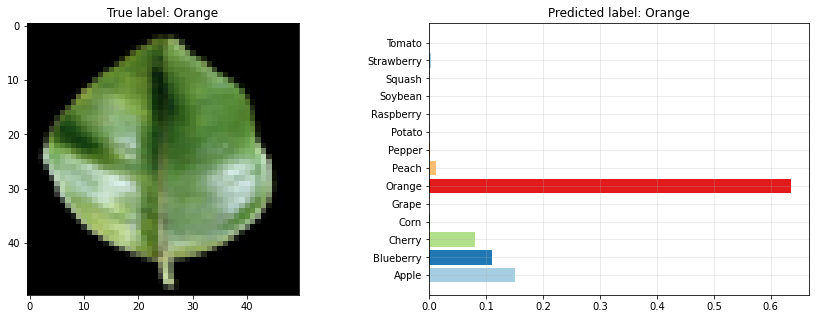

In [ ]:
# Predict the test set with the CNN
predictions = model.predict(X_test)
predictions.shape

# Plot the target images and the predictions
prediction_index = 1256
print(predictions[prediction_index])

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(15,5)
ax1.imshow(X_test[prediction_index])
ax1.set_title('True label: '+label_dict[np.argmax(y_test[prediction_index])]) 
ax2.barh(list(label_dict.values()), predictions[prediction_index], color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: '+label_dict[np.argmax(predictions[prediction_index])])
ax2.grid(alpha=.3)
plt.show()

Accuracy: 0.9199
Precision: 0.9227
Recall: 0.9197
F1: 0.9197


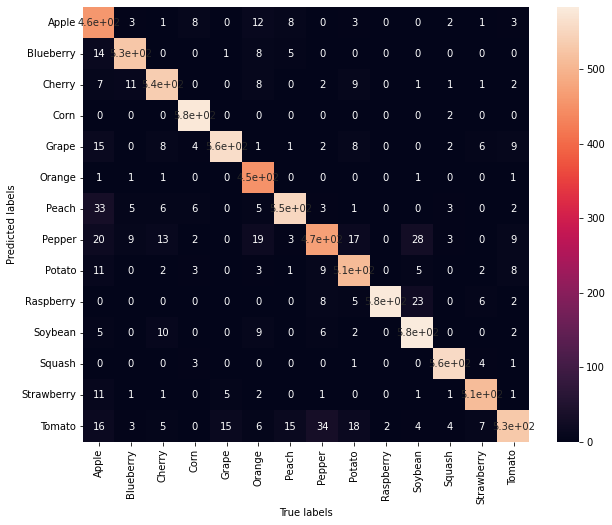

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), normalize=None)

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, annot=True, xticklabels=list(label_dict.values()), yticklabels=list(label_dict.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)
 
plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
 
plt.show()